**************************************************INITIALIZATION*********************************************************

In [1]:
from tjmonopix.tjmonopix import TJMonoPix
import time

chip = TJMonoPix()
chip['CONF']['DEF_CONF_N'] = 0
chip['CONF']['AB_SELECT'] = 1
chip['CONF'].write()
chip.init()

chip['data_rx'].CONF_START_FREEZE = 15 #default 3
chip['data_rx'].CONF_STOP_FREEZE = 100 #default 40
#chip['data_rx'].CONF_STOP_FREEZE = 250 #default 40
chip['data_rx'].CONF_START_READ = 35 #default 6
chip['data_rx'].CONF_STOP_READ = 37 #default 7
chip['data_rx'].CONF_STOP = 105 #default 45
#chip['data_rx'].CONF_STOP = 255 #default 45

chip.power_on()

chip['CONF']['RESET_BCID'] = 1
chip['CONF']['RESET'] = 1
chip['CONF'].write()

chip['CONF']['EN_BX_CLK'] = 1
chip['CONF']['EN_OUT_CLK'] = 1
chip['CONF'].write()
 
chip['CONF']['RESET_BCID'] = 0
chip['CONF']['RESET'] = 0
chip['CONF'].write()

chip.default_conf()

#-------------------------------------------------#
chip.set_icasn_dacunits(0,0)
chip.set_vreset_dacunits(35,0)
chip.set_ireset_dacunits(5,1,0)
chip.set_ithr_dacunits(30,0)
chip.set_idb_dacunits(50,0)

chip['CONF_SR']['EN_HV'].setall(False)
chip['CONF_SR']['EN_COMP'].setall(False)
chip['CONF_SR']['EN_PMOS'].setall(False)
chip['CONF_SR']['EN_PMOS_NOSF'].setall(False)
chip['CONF_SR']['EN_TEST_PATTERN'].setall(False)

chip['CONF_SR']['MASKD'].setall(False)
chip['CONF_SR']['MASKH'].setall(False)
chip['CONF_SR']['MASKV'].setall(False)

chip.write_conf()

chip['CONF']['DEF_CONF_N'] = 1
chip['CONF'].write()

2018-03-06 21:40:14,171 - [root           ] - ERROR   'NoneType' object has no attribute 'WriteExternal'
2018-03-06 21:40:14,204 - [root           ] - INFO    Found USB board(s): USBpix with ID 207 (FW 15)
2018-03-06 21:40:14,208 - [root           ] - INFO    Programming FPGA: tjmonopix_mio.bit...
2018-03-06 21:40:22,149 - [root           ] - INFO    Success!
2018-03-06 21:40:22,568 - [root           ] - INFO    Found adapter card: General Purpose Analog Card with ID 1
2018-03-06 21:40:22,590 - [root           ] - INFO    Initializing fifo (firmware version: 2), module basil.HL.sram_fifo, base_addr 0x18000
2018-03-06 21:40:22,594 - [root           ] - INFO    Initializing gpio (firmware version: 0), module basil.HL.gpio, base_addr 0x10000
2018-03-06 21:40:22,598 - [root           ] - INFO    Initializing spi (firmware version: 2), module basil.HL.spi, base_addr 0x11000
2018-03-06 21:40:22,601 - [root           ] - INFO    Initializing inj (firmware version: 3), module basil.HL.pulse_ge

4098


****************************************************POWER_STATUS*********************************************************

In [6]:
#chip['BiasSF'].set_current(100, unit='uA') # SET THE SOURCE FOLLOWER READOUT CURRENT
chip.get_power_status()

{'VDDA [V]': 1.7925618542914172,
 'VDDA [mA]': 62.43416855220045,
 'VDDA_DAC [V]': 1.7973164810756972,
 'VDDA_DAC [mA]': 3.53162464064632,
 'VDDD [V]': 1.799759839679359,
 'VDDD [mA]': -3.3934469967968035e-08,
 'VDDP [V]': 1.7937540430430434,
 'VDDP [mA]': 171.33471791232435}

****************************ENABLE_COLUMS, SET MASKS, SELECT WHICH COLUMN AND ROW TO INJECT******************************

In [4]:
# SELECT WHICH DOUBLE COLUMNS TO ENABLE
chip['CONF_SR']['EN_PMOS_NOSF'].setall(False)
chip['CONF_SR']['EN_PMOS'].setall(False)
chip['CONF_SR']['EN_COMP'].setall(False)
chip['CONF_SR']['EN_HV'].setall(False)
chip['CONF_SR']['EN_OUT'].setall(False) #ENABLES OR DISABLES THE NORMAL OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['nEN_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['EN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE NORMAL HITOR PADS, HITOR0-3 =  1-4 flavor, ACTIVE LOW
chip['CONF_SR']['nEN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY HITOR PADS, ACTIVE LOW

#chip['CONF_SR']['EN_PMOS'][9] = 1
chip['CONF_SR']['EN_PMOS'].setall(True)
#chip['CONF_SR']['EN_HITOR_OUT'][1] = 0

# SELECT WHICH PHYSICAL COLUMNS, ROWS, DIAGONALS TO MASK
# TO MASK ONE PIXEL, MASKV, MASKH and MASKD OF THIS PIXEL SHOULD BE 0 (FALSE)
# THE MASKD NUMBER OF THE PIXEL WE WANT TO MASK (or UNMASK), IS GIVEN BY: MASKD = PHYSCOL- PHYSROW
# IF PHYSCOL-PHYSROW<0, then MASKD = 448+PHYSCOL-PHYSROW
chip['CONF_SR']['MASKD'].setall(True)
chip['CONF_SR']['MASKH'].setall(True)
chip['CONF_SR']['MASKV'].setall(True)

# TO USE THE MASK FUNCTION YOU MUST INPUT THE FLAVOR, COLUMN AND ROW
# THE FLAVOR NUMERS IS: 0 FOR PMOS_NOSF, 1 FOR PMOS, 2 FOR COMP, 3 FOR HV
chip.mask(1,5,179)
chip.mask(1,59,95)
chip.mask(1,42,136)
chip.mask(1,60,137)
chip.mask(1,86,126)

chip.mask(1,102,139)
chip.mask(1,66,39)
chip.mask(1,103,154)
chip.mask(1,102,149)
chip.mask(1,38,144)
chip.mask(1,45,131)
chip.mask(1,101,131)
chip.mask(1,106,119)
chip.mask(1,0,101)
chip.mask(1,11,117)
chip.mask(1,81,51)
chip.mask(1,39,93)
chip.mask(1,80,144)
chip.mask(1,29,103)
chip.mask(1,66,129)
chip.mask(1,35,157)
chip.mask(1,13,16)
chip.mask(1,23,45)
chip.mask(1,48,157)
chip.mask(1,26,60)
chip.mask(1,102,134)
chip.mask(1,87,184)
chip.mask(1,108,1)
chip.mask(1,45,149)
chip.mask(1,24,96)
chip.mask(1,28,98)
chip.mask(1,42,210)
chip.mask(1,108,196)
chip.mask(1,71,128)

#chip['CONF_SR']['MASKD'][31] = True
#chip['CONF_SR']['MASKH'][99] = False

# SELECT WHICH PHYSICAL COLUMS TO INJECT
# INJ_IN_MON_L AND INJ_IN_MON_L SELECT THE LEFT AND RIGHT SPECIAL ANALOG MONITORING PIXELS
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)
#chip['CONF_SR']['COL_PULSE_SEL'][130]=True

chip['CONF_SR']['INJ_IN_MON_L'] = 1 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS LEFT SIDE
chip['CONF_SR']['INJ_IN_MON_R'] = 0 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS RIGHT SIDE

# SELECT WHICH PHYSICAL ROWS TO INJECT
# THE SPEXIAL PIXELS OUTA_MON3 to OUTA_MON0 CORRESPONT TO ROWS 223 to 220 FOR INJECTION
chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['INJ_ROW'][223] = True # FOR THE ANALOG MONITORING TOP PIXEL

# SELECT PHYSICAL COLUMNS AND ROWS FOR INJECTION WITH FUNCTION
chip.enable_injection(1,18,99)

# SELECT PHYSICAL COLUMN(S) FOR HITOR OUTPUT
# nMASKH (SO SETTING MASKH TO FALSE) ENABLES HITOR FOR THE SPECIFIC ROW
chip['CONF_SR']['DIG_MON_SEL'].setall(False)
#chip.enable_column_hitor(1,18)

chip.write_conf()

******************INITIALIZE COMMUNICATION, RECEIVE DATA (CHECK IF DATA ARE SENT WITH EACH EXCECUTION)*******************

In [12]:
#chip['data_rx'].CONF_START_FREEZE = 15 #default 3
#chip['data_rx'].CONF_STOP_FREEZE = 100 #default 40
#chip['data_rx'].CONF_START_READ = 35 #default 6
#chip['data_rx'].CONF_STOP_READ = 37 #default 7
#chip['data_rx'].CONF_STOP = 105 #default 45

#chip['CONF']['AB_SELECT'] = 1
#chip['CONF'].write()

chip['data_rx'].set_en(True)

x = chip['fifo'].get_data()

ix = chip.interprete_data(x)
print(len(ix))
print(ix)

0
[]


************CONFIGURE THE FRONT END CURRENT AND VOLTAGE BIASES, CONFIGURE THE HEIGHT OF THE INJECTION PULSE**************

In [19]:
## SET THE INJECTION PULSE AMPLITUDE
## 128-bit DAC (7-bit binary equivalent)
## SET THE VOLTAGES IN ONE HOT ENCODING, ONLY ONE BIT ACTIVE AT A TIME.
## V = (127/1.8)*#BIT
# The default values are VL=44, VH=79, VH-VL=35
# VDAC LSB=14.17mV, Cinj=230aF, 1.43e-/mV, ~710e-
chip.set_vl_dacunits(44,1)
chip.set_vh_dacunits(79,1)

####### CONFIGURE THE FRONT END ######

# SET VRESET_P, THIS IS THE BASELINE OF THE FRONT END INPUT, ONE HOT ENCODING
chip.set_vreset_dacunits(40,1) #1V

## 128-bit DAC (7-bit binary equivalent)
## SET THE CURRENTS USING THERMOMETER ENCODING, I = #BITS_ACTIVE*140nA*SCALING, SCALING IS DIFFERENT FOR EACH CURRENT
## SCALING: IBIAS=10, IDB=16, ITHR=0.125, ICASN=4, IRESET=0.03125
## ACTIVE BITS SHOULD BE SET STARTING FROM THE MIDDLE e.g. for 15 active bits, (128-15)/2=56,5 so 56zeros,15ones,57zeros
## Thus, Ix[71:57] = True

# SET ICASN, THIS CURRENT CONTROLS THE OUTPUT BASELINE, BE CAREFUL NOT TO SET IT TO HIGH
# ALWAYS MONITOR THE POWER AFTER SETTING ICASN. IF VDDD IS SEVERAL mA, REDUCE IT UNTIL IT RETURNS TO 0
# ICASN MAINLY CONTROLS THE THRESHOLD
chip.set_icasn_dacunits(0,1) #4.375nA # approx 1.084V at -3V backbias, 600mV at 0V backbias

# SET IRESET, THIS CURRENT CONTROLS THE RESET RATE OF THE FRONT END INPUT (ALSO THE THRESHOLD)
chip.set_ireset_dacunits(2,1,1) #270pA, HIGH LEAKAGE MODE, NORMAL SCALING, 0 = LOW LEAKAGE MODE, SCALING*0.01

# SET ITHR, THIS CURRENT CONTROLS THE RESET RATE OF THE OUTPUT (AND THE THRESHOLD)
chip.set_ithr_dacunits(5,1) #680pA

# SET ITHR, THIS CURRENT CONTROLS THE BIASING OF THE DISCRIMINATOR (AND THE THRESHOLD)
chip.set_idb_dacunits(15,1) #500nA

# SET IBIAS, THIS CURRENT IS THE DC CURRENT OF THE MAIN BRANCH OF THE FRONT END THAT PROVIDES AMPLIFICATION
# IT CONTROLS MAINLY THE RISE TIME
chip.set_ibias_dacunits(50,1) #500nA

############ ENABLE THE DAC CURRENT MONITORING ###########
# chip['CONF_SR']['SWCNTL_DACMONI'] = 0

########## SET THE BIAS CURRENTS OF THE TWO STAGE SOURCE FOLLOWER THAT BUFFERS THE ANALOG MONITORING VOLTAGES #########
# CONTROLS THE RESPONSE TIME AND THE LEVEL SHIFT OF THE BUFFER
# chip['CONF_SR']['SET_IBUFN_L'] = 0b1001
# chip['CONF_SR']['SET_IBUFP_L'] = 0b0101

chip.write_conf()

vl = 1.00862204724V
vh = 1.50468503937V
vreset = 1.12192913386V
icasn = 4.375nA
ireset = 0.1025390625nA, high leakage mode
ithr = 0.8203125nA
idb = 280.0nA
ibias = 557.8125nA


****************************SET THE INJECTION PULSE PARAMETERS, INJECT x times and get the data**************************

In [21]:
#chip['inj'].reset()

repeat=1
delay=1000
width=250
noise_en=0
col=18
row=99

chip['inj'].set_delay(1000)
chip['inj'].set_width(250)
chip['inj'].set_repeat(repeat)
chip['inj'].set_en(0)

while not chip['inj'].is_ready:
    time.sleep(0.001)

for _ in range(10):
    chip['inj'].is_ready

chip["inj"].start()
time.sleep(repeat*0.0001)

x = chip['fifo'].get_data()
ix = chip.interprete_data(x)

print(len(ix))
print(ix)

cnt2=0
for hit in ix:
    if hit['col'] == col and  hit['row'] == row:
        if noise_en == 1:
            if hit['noise'] == 0: 
                cnt2 += 1
        else:
            cnt2 += 1
print cnt2

2
[(18, 223, 59, 10, 0) (18,  99, 58, 17, 0)]
1


******************************************INJECTION SCANS -  S-CURVE*****************************************************

[   0    0    0    0    0    0    0    0    0    0    0    0    0    1
   12  256  849  996 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000]


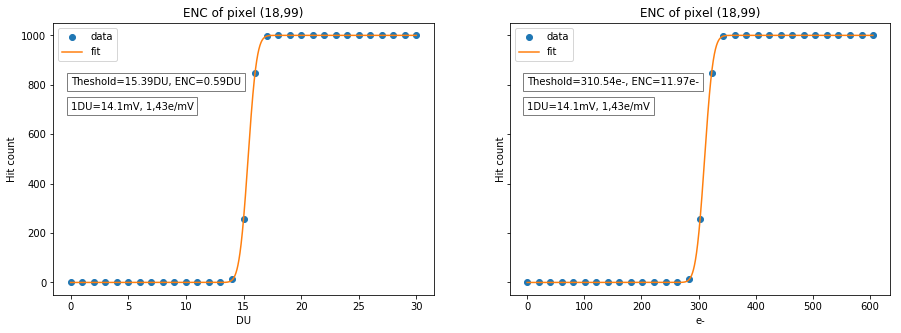

In [22]:
%matplotlib inline
import numpy as np

flavor=1
col=18
row=99
VL=40
VHLrange=30
start_dif=0
repeat=1000
delay=1000
width=250
noise_en=0
analog_en=1
sleeptime=repeat*0.0001
DUtoe=20.18
#DUtoe=23

xhits = range(start_dif,VHLrange+start_dif+1)

hits = chip.inj_scan(flavor, col, row, VL, VHLrange, start_dif, delay, width, repeat, noise_en, analog_en, sleeptime)
print hits
chip.plot_scurve(col, row, xhits, hits, repeat, VHLrange/2+start_dif, 0.5, 10.0, DUtoe)

In [ ]:
%matplotlib inline
import numpy as np

flavor=1
col=18
row=99
VL=40
VHLrange=40
start_dif=0
repeat=100
delay=1000
width=250
noise_en=1
analog_en=1
sleeptime=repeat*0.0001
DUtoe=20.18

row_low = 0
row_high = 111
col_low = 10
col_high = 30

pix_no = (col_high-col_low+1)*(row_high-row_low+1)

scurve = np.zeros((pix_no,VHLrange+1), dtype=int)
xhits = range(start_dif,VHLrange+start_dif+1)

i = 0
for col in range(col_low,col_high+1):
    for row in range(row_low,row_high+1):
        hits = chip.inj_scan(flavor, col, row, VL, VHLrange, start_dif, delay, width, repeat, noise_en, analog_en, sleeptime)
        print i
        scurve[i] = hits
        i += 1
        print hits
        time.sleep(0.5)
    
#print scurve
np.save('scurvedata.npy',scurve)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib import colors
#import matplotlib.colors as colors

scurves = np.load('scurvedata.npy')
scurves = np.delete(scurves, (np.where(~scurves.any(axis=1))[0]), axis=0)

repeat=100
param_count = scurve.shape[1]
max_occ = repeat + 10

hist = np.empty([param_count, max_occ], dtype=np.uint32)
for param in range(param_count):
    hist[param] = np.bincount(scurves[:, param], minlength=max_occ)#[:max_occ]
             
print hist

plt.pcolormesh(np.arange(0, param_count*DUtoe, DUtoe), range(max_occ), hist.T, norm=colors.LogNorm())
plt.colorbar()
plt.xlabel('Injection [e-]')
plt.show()